# DIST-ALERT V1 validation

#### Summary results
DIST-ALERT_v1
For each observed date through the time-series, no-dist and ongoing-dist are compared against the reference time-series for the previous 30 days and finished-dist are compared against the reference time-series year to date. A disturbance must persist in the reference data for at least 15 days (this defends well with the map moving window being +-15 days).

- High magnitude loss for both map and reference (Map ≥50%, ref VLmaj): Users 62.9 ±50.8, Producers 54.2±16.1
    - only confirmed: users 72.8 ±22.6, producers 53.7 ±16.2
- Map high loss, ref any loss: users 81.4 ±62.2
    - only confirmed: **users 94.5 ±11.7**
    - only confirmed, reference lookback of 60 days: users 98.6 ±5.2
    - only confirmed, reference lookback of 60 days, duration 5: **users 99.4 ±1.9**
    - only confirmed, reference lookback of 60 days, duration 10: users 99.2 ±3.1
- Map any loss, ref high loss: **producers 89.4 ±7.8**
    - only confirmed: producers 87.6 ±8.4
    - Lookback 1 day: **producers 91.0 ±7.8**
    - Only confirmed, lookback 1 day: producers 89.5 ±8.3
- Map any loss, ref any loss: users 42.9 ±21.9 prod 63.6 ±26.1
    - Only confirmed: users 70.5 ±10.7 prod 59.0 ±25.2

All of these variations have overall accuracy >98%. For the variations where only users or producers are listed, the other is abysmal (almost by definition).

This means that 63% of high loss alerts were also high loss in the reference with an additional 19% having loss labeled “minority” in the reference. For only confirmed this is 73% and an additional 22% as “minority”. Out of all the “majority” loss identified in the reference, 89% was detected by the product with 88% reaching confirmed status.


### Import strata and sample unit information

In [1]:
# Import strata and sample unit information
import sys 
import math
import datetime

mapsource = "mapLabelsv1sample"
ANNname = "v1sample"
sampleDict = {}
sampleFull = {}
strata = {}
with open("sampledpixels1214.csv",'r') as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS) = l.strip().split(',')
    sampleDict[ID] = ','.join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
ids = sampleDict.keys()

#missingBaseline = []#[3,28,87,113,138,139,154,167,205,245]
#missingBaseline_ve = []#[3,28,113,138,139,205,245]
#badQA = [41,85,147]
#refVLmaj = []#[13]

#Strata area
strataAreas = {}
strataCounts = {}
with open("stratatable_0119_z.txt",'r') as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K,zcount) = l.strip().split('\t')
  strataAreas[s] = float(area)
  strataCounts[s] = int(zcount)
Nstrata = len(strataCounts)

### Functions to read in map and reference data and calculate accuracy

In [2]:
def getDISTALERTStatus_vI(skipNodata=False):
    #print(skipNodata)
    mapalert = {}
    for ID in ids:
        mapalert[ID] = [255 for i in range(0,366)]
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
            header = lines[0]
            maplist = lines[1:]
            for line in maplist:
                (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
                day = dayDiff("20211001",SensingTime)
                
                if not (skipNodata and int(VEGIND)==255):
                    if int(VEGDISTSTATUS) in [1,2,3,7] and int(VEGANOMMAX) < 10:
                        mapalert[ID][day] = 0
                    else:
                        mapalert[ID][day] = int(VEGDISTSTATUS)

    return mapalert

In [3]:
def dayDiff(start,end):
  startdate = datetime.datetime.strptime(start,"%Y%m%d")
  enddate = datetime.datetime.strptime(end,"%Y%m%d")
  days = enddate-startdate
  return (days.days+1)

In [4]:
def getRefALERTbinaryDaily(yeslabels,nolabels):
  refalert = {}
  with open('referenceTimeSeries_last.csv','r') as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    daily = fields[5:]
    refalert[ID] = [0 for i in range(0,365)]
    for day in range(0,365):
      found = False
      for l in yeslabels:
        if l == daily[day]:
          found = True
        #if l in daily[day] and int(ID) in refVLmaj:
        #  found = True
      if found:
        refalert[ID][day] = 2
      else:
        for l in nolabels:
          if l == daily[day]:
            found = True
        if found:
          refalert[ID][day] = 1
        else:
          refalert[ID][day] = 0
  return refalert

In [5]:
def alertConfusionMatrix_vTS2(cat,map,ref,strataCounts,mincount,excludelist,Ndays,name,printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  with open(name+".txt",'w') as OUT:
        "ID,agree_no,commission,omission,agree_loss,total\n"
  #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};

  if cat == "lt50":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = [7,8]
  if cat == "provlt50":
        nodist = [0]
        dist = [2,3,5,6]
        old = [7,8]
  if cat == "lt50_onlyprov":
        nodist = [0]
        dist = [2,5]
        old = []
  if cat == "onlylt50":
        nodist = [0]
        dist = [1,2,3]
        old = [7]
  if cat == "gt50":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = [8]
  if cat == "provgt50":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = [8]
  if cat == "gt50_onlyprov":
        nodist = [0,1,2,3,7]
        dist = [5]
        old = []
  if cat == "confgt50":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = [8]
  if cat == "provgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = []  
  if cat == "confgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = []
  if cat == "conflt50":
        nodist = [0]
        dist = [3,6]
        old = [7,8]
  if cat == "conflt50_curr":
        nodist = [0]
        dist = [3,6]
        old = []
  #confusion matrix
  for ID in ids:
    p = [[0,0,0],[0,0,0],[0,0,0]]
    ptotal = 0
    for d in range(0,365):
      #print(ref[ID][d], map[ID][d])
      if not int(ID) in excludelist:
        if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 255:
            start = (d>Ndays)*(d-Ndays)
            if map[ID][d] in nodist:
                mapVal=1
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            elif map[ID][d] in dist:
                mapVal=2
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            elif map[ID][d] in old:
                mapVal=2
                if ref[ID][0:(d+mincount)].count(2) > mincount:
                    refVal=2
                else:
                    refVal=1
            else:
                mapVal=0
                refVal=0
            if refVal>0 and mapVal>0:
                p[refVal][mapVal] += 1
                ptotal += 1
            #if refVal != mapVal and refVal>0 and mapVal>0:
            #    print(ID, d, map[ID][d],mapVal, refVal,ref[ID][start:(d+1)])
    if ptotal>0:
      #if p[1][2]/ptotal >0 and p[2][2]==0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",round(p[2][2]/ptotal,3),"comm: ", round(p[1][2]/ptotal,3), "om: ", round(p[2][1]/ptotal,3))
      with open(name+".txt",'a') as OUT:
        OUT.write(str(ID)+","+str(p[1][1])+","+str(p[1][2])+","+str(p[2][1])+","+str(p[2][2])+","+str(ptotal)+"\n")
      ntotal[strata[ID]] += (p[1][1]+p[1][2]+p[2][1]+p[2][2])/ptotal
      for r in [1,2]:
        for m in [1,2]:
          n[strata[ID]][r][m] += (p[r][m]/ptotal)
    #print(ptotal,end=",")
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [6]:
def accuracy(n, ntotal, strataCounts,name,write=True):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])

  #Accuracy
  overall = 0
  y = 0
  usersx = 0
  producersx = 0
  OAsub = 0
  area = [[0,0],[0,0]]
  for s in range(1,Nstrata):
    #overall
    overall += ((n[s][1][1] + n[s][2][2])/ntotal[s])*(N[str(s)]/Ntotal)
    oyhmean = (n[s][1][1] + n[s][2][2])/ntotal[s]
    sampvaryhOA = ((n[s][1][1] + n[s][2][2])*((1-oyhmean)**2) + (n[s][1][2] + n[s][2][1])*((0-oyhmean)**2))/(ntotal[s]-1)
    OAsub += N[str(s)]*N[str(s)]*(1-ntotal[s]/N[str(s)])*sampvaryhOA/(ntotal[s])*(1/Ntotal**2)

    #users and producers
    y += (n[s][2][2]/ntotal[s])*N[str(s)]
    usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
    producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[str(s)]
    
    #print("strata",s,n[s][1][1],n[s][1][2],n[s][2][1],n[s][2][2])
    for i in range(1,3):
      for j in range(1,3):
        area[i-1][j-1] += (n[s][i][j]/ntotal[s])*(N[str(s)]/Ntotal)
  
  print(area[0][0]*100,area[0][1]*100)
  print(area[1][0]*100,area[1][1]*100)

  overall = overall*100
  overallSE = math.sqrt(OAsub)*100
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  PAsub1 = 0
  PAsub2 = 0
  for s in range(1,Nstrata):
    #users and producers
    yhmean = n[s][2][2]/ntotal[s]
    yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
    
    if users != "NA":
        if (n[s][1][2]+n[s][2][2]) > 0:
            xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
            xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
            xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
            UAsub1 += N[str(s)]*xuhmean
            UAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
    
    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0:
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[str(s)]*xphmean
            PAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]

  
  if users != "NA":
    usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    users = users*100
  else:
    usersSE = "NA"
  if producers != "NA":
    producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    producers = producers*100
  else:
    producersSE = "NA"
  print("Overall:",overall," +-", overallSE)
  print("Users:",users," +-", usersSE)
  print("Producers:",producers," +-", producersSE)
  if write:
    with open("accuracy.csv",'a') as OUT:
        OUT.write(','.join([name,str(overall),str(overallSE),str(users),str(usersSE),str(producers),str(producersSE)])+"\n")


## Calculate accuracy under different filtering/grouping rules

In [28]:
#strata enum {CONFHIVEG=6, PROVHIVEG=5, CONFLOWVEG=4,PROVLOWVEG=3,GENDIST=2,NODIST=1,NODATA=0};
mapsource = "mapLabelsv1sample"
for cattype in ["gt50","lt50","confgt50","conflt50"]:#["gt50_onlyprov","confgt50_curr","provgt50_curr","gt50","lt50","provgt50","provlt50","gt50_onlyprov","lt50_onlyprov","confgt50","conflt50"]:
    basename = "v1sample_"+cattype
    map = getDISTALERTStatus_vI(True)
    mapsimple = filterMap(map,cattype)
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)
        #with open("ref_accuracy_V1.txt","w") as OUT:
        #    OUT.write(str(ref))
        print("\n"+name)
        (n,ntotal) = alertConfusionMatrix_vTS2(cattype,map,ref,strataCounts,duration,[],lookback,name,False)
        accuracy(n,ntotal,strataCounts,name,True)
        
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)
        print("\n"+name)
        #print(mapsimple['1'])
        #print(ref['1'])
        (n,ntotal) = alertConfusionMatrix_vTS2(cattype,map,ref,strataCounts,duration,[1],lookback,name,False)
        accuracy(n,ntotal,strataCounts,name,True)


v1sample_gt50_lookback30_duration15
99.59452860117457 0.10297728007114394
0.12484349395087783 0.17765062480342445
Overall: 99.772179225978  +- 0.288701290006014
Users: 63.304689846445804  +- 64.47591973920004
Producers: 58.728621083611664  +- 15.293691721166622

v1sample_gt50_lookback30_duration15_VLmin
98.52069762465892 0.05354309568643388
1.2642525082704432 0.16150677138418654
Overall: 98.68220439604312  +- 0.9034156087585992
Users: 75.1020094009866  +- 96.92455275621026
Producers: 11.32777276563189  +- 7.939626391713577

v1sample_lt50_lookback30_duration15
97.76923717133191 1.8630803030516083
0.029527619453270388 0.3381549061632172
Overall: 98.10739207749512  +- 1.089044733101174
Users: 15.362052394384335  +- 8.555414933970482
Producers: 91.9692622313878  +- 7.0565896452584616

v1sample_lt50_lookback30_duration15_VLmin
97.15399058668919 1.1850110289411335
0.6994057539791712 0.9615926303904885
Overall: 98.11558321707969  +- 1.2325740776989278
Users: 44.79600256946804  +- 23.98460209

______________________________________________________________________________________________________________
### Funtions to calculate accuracy for different subsets of the data using a confidence threshold

In [29]:
def alertConfusionMatrix_varthresh(thresh,var,cat,map,ref,strataCounts,mincount,excludelist,Ndays,printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  
  #confusion matrix
  for ID in ids:
    p = [[0,0,0],[0,0,0],[0,0,0]]
    ptotal = 0
    for d in range(0,365):
      #print(ref[ID][d], map[ID][d])
      if not int(ID) in excludelist:
        if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 0:
            start = (d>Ndays)*(d-Ndays)
            #Map no disturbance, ref check within lookback to current day plus duration
            if map[ID][d] == 1:#in nodist:
                mapVal=1
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            #Map disturbance and above variable threshold, ref check within lookback to current day plus duration
            elif map[ID][d] == 2 and var[ID][d] >= thresh:#in dist
                mapVal=2
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            #Map old disturbance, ref check within start of year to current day plus duration
            elif map[ID][d] == 3 and var[ID][d] >= thresh:#in old
                mapVal=2
                if ref[ID][0:(d+mincount)].count(2) > mincount:
                    refVal=2
                else:
                    refVal=1
            #Map some kind of disturbance but variable less than threshold so "no", ref check within lookback to current day plus duration
            #only affects omission --and this is where we want to account for it.
            else:
                mapVal=1
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            if refVal>0 and mapVal>0:
                p[refVal][mapVal] += 1
                ptotal += 1
            #if refVal != mapVal and refVal>0 and mapVal>0:
            #    print(ID, d, map[ID][d],mapVal, refVal,ref[ID][start:(d+1)])
    if ptotal>0:
      #if p[1][2]/ptotal >0 and p[2][2]==0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",round(p[2][2]/ptotal,3),"comm: ", round(p[1][2]/ptotal,3), "om: ", round(p[2][1]/ptotal,3))
      #if p[1][2] > 0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",p[2][2],"comm: ",p[1][2], "om: ", p[2][1])
      #if p[2][2]>0:
      #  p[1][2]=0
      #  p[2][1]=0
      ntotal[strata[ID]] += (p[1][1]+p[1][2]+p[2][1]+p[2][2])/ptotal
      for r in [1,2]:
        for m in [1,2]:
          n[strata[ID]][r][m] += (p[r][m]/ptotal)
    #print(ptotal,end=",")
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          j=m
          #print(n[s][r][m],end=",")
      if (n[s][1][2]+n[s][2][2])>0:
          print(s,N[str(s)]*n[s][1][2]/(n[s][1][2]+n[s][2][2])/1000000000)
  return (n,ntotal)

In [30]:
def alertConfusionMatrix_varbin(vbin,var,cat,map,ref,strataCounts,mincount,excludelist,Ndays,printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  
  #confusion matrix
  for ID in ids:
    p = [[0,0,0],[0,0,0],[0,0,0]]
    ptotal = 0
    for d in range(0,365):
      #print(ref[ID][d], map[ID][d])
      if not int(ID) in excludelist:
        if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 0:
            start = (d>Ndays)*(d-Ndays)
            #Map no disturbance, ref check within lookback to current day plus duration
            if map[ID][d] == 1:#in nodist:
                mapVal=1
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            #Map disturbance and above variable threshold, ref check within lookback to current day plus duration
            elif map[ID][d] == 2 and var[ID][d] >= vbin[0] and var[ID][d] <= vbin[1]:#in dist
                mapVal=2
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            #Map old disturbance, ref check within start of year to current day plus duration
            elif map[ID][d] == 3 and var[ID][d] >= vbin[0] and var[ID][d] <= vbin[1]:#in old
                mapVal=2
                if ref[ID][0:(d+mincount)].count(2) > mincount:
                    refVal=2
                else:
                    refVal=1
            ########not any more, no data#Map some kind of disturbance but variable less than threshold so "no", ref check within lookback to current day plus duration
            else:
                mapVal=0
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refVal=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refVal=1
                else:
                    refVal=0
            if refVal>0 and mapVal>0:
                p[refVal][mapVal] += 1
                ptotal += 1
            #if refVal != mapVal and refVal>0 and mapVal>0:
            #    print(ID, d, map[ID][d],mapVal, refVal,ref[ID][start:(d+1)])
    if ptotal>0:
      #if p[1][2]/ptotal >0 and p[2][2]==0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",round(p[2][2]/ptotal,3),"comm: ", round(p[1][2]/ptotal,3), "om: ", round(p[2][1]/ptotal,3))
      #if p[2][2]>0:
      #  p[1][2]=0
      #  p[2][1]=0
      ntotal[strata[ID]] += (p[1][1]+p[1][2]+p[2][1]+p[2][2])/ptotal
      for r in [1,2]:
        for m in [1,2]:
          n[strata[ID]][r][m] += (p[r][m]/ptotal)
    #print(ptotal,end=",")
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      if (n[s][1][2]+n[s][2][2])>0:
        print(n[s][1][2]/(n[s][1][2]+n[s][2][2]))
  return (n,ntotal)

In [31]:
def getDISTALERT_vI_var(variable):
    mapalert = {}
    for ID in ids:
        mapalert[ID] = [255 for i in range(0,366)]
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
            header = lines[0]
            maplist = lines[1:]
            for line in maplist:
                (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
                day = dayDiff("20211001",SensingTime)

                if variable == "conf":
                    mapalert[ID][day] = int(VEGDISTCONF)
                elif variable == "dur":
                    mapalert[ID][day] = int(VEGDISTDUR)
                elif variable == "count":
                    mapalert[ID][day] = int(VEGDISTCOUNT)
                elif variable == "maxanom":
                    mapalert[ID][day] = int(VEGANOMMAX)
                else:
                    print("bad variable name")

    return mapalert

_______________________________________________________________________
#### User's accuracy for alerts with increasing confidence thresholds

In [33]:
def usersAccuracy(n, ntotal, strataCounts,name,write=True):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])

  #Accuracy
  y = 0
  usersx = 0
  for s in range(1,Nstrata):
    #users and producers
    y += (n[s][2][2]/ntotal[s])*N[str(s)]
    usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
    #print(s,"ref no, map yes:", n[s][1][2],"yes agree",n[s][2][2])
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  for s in range(1,Nstrata):
    #users and producers
    yhmean = n[s][2][2]/ntotal[s]
    yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
    
    if users != "NA":
        if (n[s][1][2]+n[s][2][2]) > 0:
            xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
            xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
            xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
            UAsub1 += N[str(s)]*xuhmean
            UAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
  
  if users != "NA":
    if UAsub1>0 and UAsub2>0:
        usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    else:
        usersSE = math.nan
    users = users*100
  else:
    users = math.nan
    usersSE = math.nan
  #print("Users:",users," +-", usersSE)
  return [users,usersSE]
  #if write:
  #  with open("accuracy.csv",'a') as OUT:
  #      OUT.write(','.join([name,str(overall),str(overallSE),str(users),str(usersSE),str(producers),str(producersSE)])+"\n")

In [34]:
#User's accuraccy for increasing confidence >= to confidence level
map = getDISTALERTStatus_vI(True)
for cattype in ["gt50"]:#map ≥50% loss
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    for duration in [15]:
      for lookback in [30]:
        usersConfVLmin = []
        for confThresh in range(50,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref all veg loss
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[201,269],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConfVLmin.append([confThresh] + usersAccuracy(n,ntotal,strataCounts,name))
    
    mapFiltered = filterMap(map,cattype)
    for duration in [15]:
      for lookback in [30]:
        usersConf = []
        for confThresh in range(50,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref all veg loss
            #print("\n"+name)
            #print(mapFiltered['93'])
            #print(ref['93'])
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[201,269],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConf.append([confThresh] + usersAccuracy(n,ntotal,strataCounts,name))

for cattype in ["lt50"]:#map ≥50% loss
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        usersConflt50VLmin = []
        for confThresh in range(10,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref all veg loss
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[201,269],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConflt50VLmin.append([confThresh] + usersAccuracy(n,ntotal,strataCounts,name))
            
#for row in usersConfVLmin:
#    print(row)
##    
#for row in usersConf:
#    print(row)

In [35]:
#User's accuraccy for increasing confidence bins
intervals = [0,100,250,500,900]#range(0,600,50)

map = getDISTALERTStatus_vI(True)
for cattype in ["gt50"]:#map ≥50% loss
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    for duration in [15]:
      for lookback in [30]:
        usersConfBinVLmin = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref all veg loss
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConfBinVLmin.append([intervals[i]+(intervals[i+1]-intervals[i])/2] + usersAccuracy(n,ntotal,strataCounts,name))
            
    for duration in [15]:
      for lookback in [30]:
        usersConfBin = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref all veg loss
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConfBin.append([intervals[i]+(intervals[i+1]-intervals[i])/2] + usersAccuracy(n,ntotal,strataCounts,name))

for cattype in ["lt50"]:#map ≥50% loss
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        usersConfBinlt50VLmin = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref all veg loss
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            #accuracy(n,ntotal,strataCounts,name)
            usersConfBinlt50VLmin.append([intervals[i]+(intervals[i+1]-intervals[i])/2] + usersAccuracy(n,ntotal,strataCounts,name))
            
#for row in usersConfVLmin:
#    print(row)
#    
#for row in usersConf:
#    print(row)

_______________________________________________________________________
#### Producer's accuracy for alerts with increasing confidence thresholds

In [36]:
def producersAccuracy(n, ntotal, strataCounts,name,write=True):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])

  #Accuracy
  y = 0
  producersx = 0
  for s in range(1,Nstrata):
    #users and producers
    y += (n[s][2][2]/ntotal[s])*N[str(s)]
    producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[str(s)]
    #print(s,"ref yes, map no:", n[s][2][1],"yes agree",n[s][2][2])
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  PAsub1 = 0
  PAsub2 = 0
  for s in range(1,Nstrata):
    #users and producers
    yhmean = n[s][2][2]/ntotal[s]
    yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)

    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0:
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[str(s)]*xphmean
            PAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]
  
  if producers != "NA":
    producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    producers = producers*100
  else:
    producers = math.nan
    producersSE = math.nan#"NA"

  #print("Producers:",producers," +-", producersSE)
  return [producers,producersSE]
  #if write:
  #  with open("accuracy.csv",'a') as OUT:
  #      OUT.write(','.join([name,str(overall),str(overallSE),str(users),str(usersSE),str(producers),str(producersSE)])+"\n")


In [37]:
#Producer's accuracy for increasing confidence >= to confidence level
map = getDISTALERTStatus_vI(True)
for cattype in ["lt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConf = []
        for confThresh in range(10,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConf.append([confThresh] + producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)

for cattype in ["lt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConfVLmin = []
        for confThresh in range(10,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConfVLmin.append([confThresh] + producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)

for cattype in ["gt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConfgt50 = []
        for confThresh in range(10,500,10):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varthresh(confThresh,conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConfgt50.append([confThresh] + producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)
#for row in producersConf:
#    print(row)

In [38]:
#Producer's accuracy for increasing confidence bins
intervals = [0,50,100,200,400,600,800]#range(0,600,50)

map = getDISTALERTStatus_vI(True)
for cattype in ["lt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConfBin = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConfBin.append([intervals[i]+(intervals[i+1]-intervals[i])/2]+ producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)

for cattype in ["lt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConfBinVLmin = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConfBinVLmin.append([intervals[i]+(intervals[i+1]-intervals[i])/2] + producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)

for cattype in ["gt50"]:#map all loss thresholds
    basename = "v1sample_"+cattype
    conf = getDISTALERT_vI_var("conf")
    mapFiltered = filterMap(map,cattype)
    
    for duration in [15]:
      for lookback in [30]:
        producersConfBingt50 = []
        for i in range(0,len(intervals)-1):
            name = basename+"_conf"+str(confThresh)+"_lookback"+str(lookback)+"_duration"+str(duration)#+"_VLmin"
            noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
            ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)#ref only veg maj and veg total
            #print("\n"+name)
            (n,ntotal) = alertConfusionMatrix_varbin([intervals[i],intervals[i+1]-1],conf,cattype,mapFiltered,ref,strataCounts,duration,[],lookback)
            producersConfBingt50.append([intervals[i]+(intervals[i+1]-intervals[i])/2] + producersAccuracy(n,ntotal,strataCounts,name))
            #accuracy(n,ntotal,strataCounts,name)
#for row in producersConf:
#    print(row)

### Calculate latency

In [39]:
def getRefALERTDateDaily(yeslabels,nolabels,adjusted):
  refdate = {}
  deltalist = [ [] for s in range(Nstrata+1)]
  with open('referenceTimeSeries_last.csv','r') as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    daily = fields[5:]
    refdate[ID] = [-1 for i in range(0,366)]
    for day in range(0,365):
      found = False
      for l in yeslabels:
        if l == daily[day]:
          found = True
        #if l in daily[day] and int(ID) in refVLmaj:
        #  found = True
      if found:
        if day==0:
            refdate[ID][day] = 1
        elif refdate[ID][day-1]>0:
            refdate[ID][day] = refdate[ID][day-1]
        elif refdate[ID][day-1] == 0:
            refdate[ID][day] = day+1
        else:
            i=1
            while((day-i)>=0 and refdate[ID][day-i]==-1):#potentially could have loss nodat loss...
                i+=1
            if refdate[ID][day-i]>0:
                refdate[ID][day] = refdate[ID][day-i]
            else:
                deltalist[strata[ID]].append((i/2))
            if adjusted:
                refdate[ID][day] = (day-i/2)+1
            else:
                refdate[ID][day] = day+1
      else:
        for l in nolabels:
          if l == daily[day]:
            found = True
        if found:
          refdate[ID][day] = 0
        else:
          refdate[ID][day] = -1
  return (refdate,deltalist)

In [40]:
def getDISTALERTDate_vI(skipNodata,adjusted):
    mapdate = {}
    for ID in ids:
        mapdate[ID] = [-1 for i in range(0,366)]
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
        header = lines[0]
        maplist = lines[1:]
        for line in maplist:
            (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
            day = dayDiff("20211001",SensingTime)
            
            if not (skipNodata and int(VEGIND)==255):
                if VEGDISTDATE == "NA" and VEGIND==255:
                    mapdate[ID][day] = -1
                elif VEGDISTDATE == "NA":
                    mapdate[ID][day] = 0
                else:
                    if adjusted:
                        i=1
                        while((day-i)>=1 and mapdate[ID][day-i]==-1):
                           i+=1
                        if day-1>=1:
                            if mapdate[ID][day-i] == 0:
                                mapdate[ID][day] = (day-i/2)
                            else:
                                mapdate[ID][day] = mapdate[ID][day-i]#dayDiff("20211001",VEGDISTDATE)
                        else:
                            mapdate[ID][day-i] == dayDiff("20211001",VEGDISTDATE)/2
                    else:
                        mapdate[ID][day] = dayDiff("20211001",VEGDISTDATE)

    return mapdate

In [41]:
def estimateDetectionLag(cat,map,ref,mapdate,refdate,strataCounts,mincount,excludelist,Ndays):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
    ndeltaSum = [0 for s in range(Nstrata+1)]
    nCount = [0 for s in range(Nstrata+1)]
    aCount = [0 for s in range(Nstrata+1)]
    deltaList = [ [] for s in range(Nstrata+1)]

    #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};
    deltaDate = {}
    if cat == "lt50":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = [7,8]
    if cat == "gt50":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = [8]
    if cat == "confgt50":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = [8]
    if cat == "conflt50":
        nodist = [0]
        dist = [3,6]
        old = [7,8]
    #confusion matrix
    for ID in ids:
        ptotal = 0
        atotal = 0
        deltaTotal = 0
        deltaDate[ID] = [-1 for i in range(0,366)]
        for d in range(0,365):
            #print(ref[ID][d], map[ID][d])
            if not int(ID) in excludelist:
                if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 255:
                    start = (d>Ndays)*(d-Ndays)
                    if map[ID][d] in dist:
                        if ref[ID][start:(d+mincount)].count(2) > mincount:
                            i=0
                            while(refdate[ID][d-i]<=0):
                                i+=1
                            deltaDate[ID][d] = mapdate[ID][d]-refdate[ID][d-i]
                            if deltaDate[ID][d]<0:
                                deltaDate[ID][d] = 0
                            deltaTotal +=deltaDate[ID][d]
                            atotal += 1
                            ptotal += 1
                        elif ref[ID][start:(d+1)].count(1) > 0:
                            ptotal += 1
                    if map[ID][d] in nodist:
                        if ref[ID][start:(d+mincount)].count(2) > mincount or ref[ID][start:(d+1)].count(1) > 0:
                            ptotal += 1
                        
        if ptotal>0:
            nCount[strata[ID]] += 1
        if atotal>0:
            aCount[strata[ID]] += 1
            ndeltaSum[strata[ID]] += (deltaTotal/atotal)
            deltaList[strata[ID]].append(deltaTotal/atotal)

    (sampleMean,SE) = getMean(deltaList)
    
    return (sampleMean,SE)#,deltaDate)


In [42]:
def getMean(deltalist):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
    
    denom = 0
    deltaSum = 0
    variance = 0
    for s in range(1,Nstrata):
        scount = len(deltalist[s])
        if scount>0:
            smean = sum(deltalist[s])/scount
            if scount > 1:
                ssum = 0
                for i in deltalist[s]:
                    ssum += (i-smean)**2
                sv = (1/(scount-1))*ssum
                variance += (N[str(s)]/Ntotal)**2 * ((N[str(s)]-scount)/(N[str(s)]-1)) * sv/scount
                #variance += (N[str(s)])**2 * ((N[str(s)]-aCount[s])/(N[str(s)]-1)) * sv/aCount[s]
                #print(s,aCount[s],smean,math.sqrt(sv))
            
            denom += (scount * (N[str(s)]))
            deltaSum += smean * (scount * (N[str(s)]))
            
    sampleMean = deltaSum/denom
    SE = math.sqrt(variance)
            
    return (sampleMean,SE)#,deltaDate)

In [44]:
def printDictionary(dict,name):
    with open(name,'w') as OUT:
        for i in dict.keys():
            days = dict[i]
            OUT.write(i+","+','.join(str(x) for x in days)+"\n")
           

In [45]:
mapsource = "mapLabelsv1sample"
for cattype in ["lt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = "v1sample_"+cattype
    map = getDISTALERTStatus_vI(True)
    mapdate = getDISTALERTDate_vI(True,False)
    printDictionary(mapdate,"mapv1sample_date.csv")
    
    for refAdj in [True,False]:
        for duration in [15]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,map,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                (n,ntotal) = alertConfusionMatrix_vTS2(cattype,map,ref,strataCounts,duration,[],lookback,name,False)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print(name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data\n")

v1sample_lt50_lookback30_duration15_VLmin 18.76 +/- 0.46 day mean lag, 3.68 +/- 0.3 day mean uncertainty in the reference data

v1sample_lt50_lookback30_duration15_VLmin 15.94 +/- 0.4 day mean lag, 3.68 +/- 0.3 day mean uncertainty in the reference data



### Calculate accuracy as a function of lag

In [50]:

def alertConfusionMatrix_lag(map,ref,mapdate,refdate,strataCounts,mincount,excludelist,Ndays,name,lagx,printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]

  #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};

  #confusion matrix
  for ID in ids:
    p = [[0,0,0],[0,0,0],[0,0,0]]
    ptotal = 0
    for d in range(0,365):
            if map[ID][d] <=2:
                mapVal =map[ID][d]
            else:
                mapVal = 0
            refVal=ref[ID][d]
            
            if refVal>0 and mapVal>0:
                #if refVal==2:
                #    print(ID, d,ref[ID][d],map[ID][d])
                p[refVal][mapVal] += 1
                ptotal += 1

    if ptotal>0:
      #if p[1][2]/ptotal >0 and p[2][2]==0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",round(p[2][2]/ptotal,3),"comm: ", round(p[1][2]/ptotal,3), "om: ", round(p[2][1]/ptotal,3))
      with open(name+".txt",'a') as OUT:
        OUT.write(str(ID)+","+str(p[1][1])+","+str(p[1][2])+","+str(p[2][1])+","+str(p[2][2])+","+str(ptotal)+"\n")
      ntotal[strata[ID]] += (p[1][1]+p[1][2]+p[2][1]+p[2][2])/ptotal
      for r in [1,2]:
        for m in [1,2]:
          n[strata[ID]][r][m] += (p[r][m]/ptotal)
    #print(ptotal,end=",")
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [48]:
def convertRef(ref,mincount,Ndays):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
    n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
    ntotal = [0 for s in range(Nstrata+1)]
    #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};
    refout = {}
    #confusion matrix
    for ID in ids:
        refout[ID] = [0 for d in range(0,365)]
        p = [[0,0,0],[0,0,0],[0,0,0]]
        ptotal = 0
        for d in range(0,365):
            #if max(ref[ID][0:(d+1)])>0:
                start = (d>Ndays)*(d-Ndays)
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refout[ID][d]=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refout[ID][d]=1
                else:
                    refout[ID][d]=0
    return refout


In [59]:
mapsource = "mapLabelsv1sample"
for cattype in ["gt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = "v1sample_"+cattype+"_VLmin"
    map = getDISTALERTStatus_vI(False)
    map = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
    printDictionary(mapdate,"mapv1sample_date.csv")
     
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,True)
        #lag = estimateDetectionLag(cattype,map,ref,mapdate,refdate,strataCounts,duration,[],lookback)
        print(name, "\n")
        usersND = []; usersNDSE = [];
        for lagx in range(0,100):#[5,10,15,20,25,30,35,40,45,50]:#range(15,20):
            mapFiltered = map
            for ID in ids:
                for d in range(0,366):
                    if (d - mapdate[ID][d])>lagx and map[ID][d]==2:
                        map[ID][d] =0
                    elif mapdate[ID][d] > 0 and map[ID][d]==2:
                        last = min(mapdate[ID][d]+lagx,365)
                        mapVal = 0
                        for x in range(mapdate[ID][d],last):
                            if map[ID][x] !=0:
                                mapVal = map[ID][x]
                        if mapVal == 1:
                            #print(map[ID][mapdate[ID][d]:last])
                            for x in range(mapdate[ID][d],last):
                                if map[ID][x]==2:
                                    map[ID][x]=0
                                    #print(ID,x)
                            #print(map[ID][mapdate[ID][d]:last])
                        #if mapVal == 2:
                            #print(map[ID][mapdate[ID][d]:last])
                #print(ID,map[ID].count(2),ref[ID].count(2))
            (n,ntotal) = alertConfusionMatrix_lag(map,ref,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
                  
            usersND.append(usersAccuracy(n,ntotal,strataCounts,name))

for cattype in ["gt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = "v1sample_"+cattype+"_VLmin"
    map = getDISTALERTStatus_vI(True)
    map = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    printDictionary(mapdate,"mapv1sample_date.csv")
     
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal","VLmin"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,True)
        #lag = estimateDetectionLag(cattype,map,ref,mapdate,refdate,strataCounts,duration,[],lookback)
        print(name, "\n")
        users = []; usersSE = [];
        for lagx in range(0,100):#[5,10,15,20,25,30,35,40,45,50]:#range(15,20):
            mapFiltered = map
            for ID in ids:
                for d in range(0,366):
                    if (d - mapdate[ID][d])>lagx and map[ID][d]==2:
                        map[ID][d] =0
                    elif mapdate[ID][d] > 0 and map[ID][d]==2:
                        last = min(mapdate[ID][d]+lagx,365)
                        mapVal = 0
                        for x in range(mapdate[ID][d],last):
                            if map[ID][x] !=0:
                                mapVal = map[ID][x]
                        if mapVal == 1:
                            #print(map[ID][mapdate[ID][d]:last])
                            for x in range(mapdate[ID][d],last):
                                if map[ID][x]==2:
                                    map[ID][x]=0
                                    #print(ID,x)
                            #print(map[ID][mapdate[ID][d]:last])
                        #if mapVal == 2:
                            #print(map[ID][mapdate[ID][d]:last])
                #print(ID,map[ID].count(2),ref[ID].count(2))
            (n,ntotal) = alertConfusionMatrix_lag(map,ref,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
                  
            users.append(usersAccuracy(n,ntotal,strataCounts,name))
#print(users)


v1sample_gt50_VLmin_lookback30_duration15 

v1sample_gt50_VLmin_lookback30_duration15 



In [60]:
for cattype in ["lt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = "v1sample_"+cattype
    map = getDISTALERTStatus_vI(False)
    map = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
    printDictionary(mapdate,"mapv1sample_date.csv")
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal"],noLabels,False)
        ref = convertRef(ref,duration,lookback)
        #print(refdate['1'])
        #lag = estimateDetectionLag(cattype,map,ref,mapdate,refdate,strataCounts,duration,[],lookback)
        print(name, "\n")
        producersND = [];producersNDSE = [];
        for lagx in range(0,100):
            refFiltered = {}
            #print(lagx,ref['39'])
            for ID in ids:
                refFiltered[ID] = [0 for d in range(0,365)]
                for d in range(0,365):
                    refFiltered[ID][d]=ref[ID][d]
                    if (d - refdate[ID][d])>lagx and ref[ID][d]==2:
                        refFiltered[ID][d] =0
                        #print(ID,d,refdate[ID][d])
                #print(ID,refFiltered[ID].count(2),map[ID].count(2))
            #print(lagx,refFiltered['1'])
            #omission
            (n,ntotal) = alertConfusionMatrix_lag(map,refFiltered,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
            #print(n[1][2][2],n[2][2][2],n[3][2][2],n[4][2][2],n[5][2][2],n[6][2][2])
            producersND.append(producersAccuracy(n,ntotal,strataCounts,name))

for cattype in ["lt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = "v1sample_"+cattype
    map = getDISTALERTStatus_vI(True)
    map = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    printDictionary(mapdate,"mapv1sample_date.csv")
    for duration in [15]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily(["VLmaj","VLtotal"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal"],noLabels,False)
        ref = convertRef(ref,duration,lookback)
        #print(refdate['1'])
        #lag = estimateDetectionLag(cattype,map,ref,mapdate,refdate,strataCounts,duration,[],lookback)
        print(name, "\n")
        producers = [];producersSE = [];
        for lagx in range(0,100):
            refFiltered = {}
            #print(lagx,ref['39'])
            for ID in ids:
                refFiltered[ID] = [0 for d in range(0,365)]
                for d in range(0,365):
                    refFiltered[ID][d]=ref[ID][d]
                    if (d - refdate[ID][d])>lagx and ref[ID][d]==2:
                        refFiltered[ID][d] =0
                        #print(ID,d,refdate[ID][d])
                #print(ID,refFiltered[ID].count(2),map[ID].count(2))
            #print(lagx,refFiltered['1'])
            #omission
            (n,ntotal) = alertConfusionMatrix_lag(map,refFiltered,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
            #print(n[1][2][2],n[2][2][2],n[3][2][2],n[4][2][2],n[5][2][2],n[6][2][2])
            producers.append(producersAccuracy(n,ntotal,strataCounts,name))
#for lagx in range(0,40):
#    print(lagx,"days",producers[lagx])

v1sample_lt50_lookback30_duration15 

v1sample_lt50_lookback30_duration15 



In [25]:
def filterMap(map,cat):
    mapout = {}
    #if cat == "lt50":
    #    nodist = [0]
    #    dist = [1,2,3,4,5,6]
    #    old = [7,8]
    #if cat == "gt50":
    #    nodist = [0,1,2,3,7]
    #    dist = [4,5,6]
    #    old = [8]
    #if cat == "confgt50":
    #    nodist = [0,1,2,3,7]
    #    dist = [6]
    #    old = [8]
    #if cat == "conflt50":
    #    nodist = [0]
    #    dist = [3,6]
    #    old = [7,8]
    if cat == "lt50":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = [7,8]
    elif cat == "lt50_curr":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = []
    elif cat == "provlt50":
        nodist = [0]
        dist = [2,3,5,6]
        old = [7,8]
    elif cat == "lt50_onlyprov":
        nodist = [0]
        dist = [2,5]
        old = []
    elif cat == "onlylt50":
        nodist = [0]
        dist = [1,2,3]
        old = [7]
    elif cat == "gt50":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = [8]
    elif cat == "gt50_curr":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = []
    elif cat == "provgt50":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = [8]
    elif cat == "gt50_onlyprov":
        nodist = [0,1,2,3,7]
        dist = [5]
        old = []
    elif cat == "confgt50":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = [8]
    elif cat == "provgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = []  
    elif cat == "confgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = []
    elif cat == "conflt50":
        nodist = [0]
        dist = [3,6]
        old = [7,8]
    elif cat == "conflt50_curr":
        nodist = [0]
        dist = [3,6]
        old = []
    else:
        print(cat, "not found")
    for ID in ids:
        mapout[ID] = [0 for x in range(0,366)]
        for d in range(0,366):
            if map[ID][d] in nodist:
                mapout[ID][d] = 1
            elif map[ID][d] in dist:   
                mapout[ID][d] = 2
            elif map[ID][d] in old:
                mapout[ID][d] = 3
            else:
                mapout[ID][d] = 0
    return mapout

### Plot accuracies

In [57]:
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import style
import numpy as np
from numpy import genfromtxt
import math
style.use('ggplot')

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

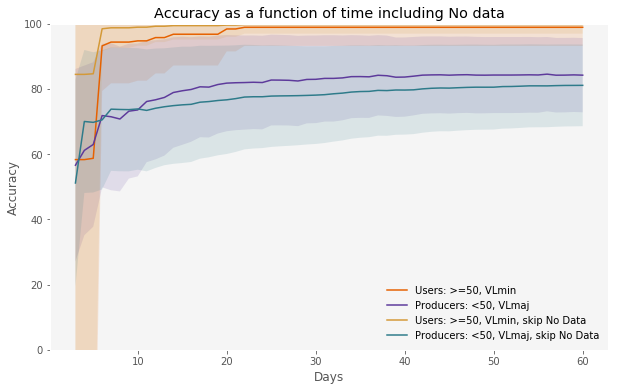

In [63]:
yuall = np.array([row[0] for row in users[0:58]])
yuerr = np.array([row[1] for row in users[0:58]])
ypall = np.array([row[0] for row in producers[0:58]])
yperr = np.array([row[1] for row in producers[0:58]])

x = range(3,61)
#pal = ["#1d3251","#003251","#1c5c68","#81b6bd","#61b6bd","#accbc7","#005c68","#8ccbc7"]#["#173f5f","#3caea3","#20639b","#88deb0"]#"#20639b","#9cfec3"]
plt.clf()
fig=0
#fig = matplotlib.pyplot.figure(figsize=(8.0, 5.0)) # in inches!
labs = ['Users: >=50, VLmin','Producers: <50, VLmin']

#plt.stackplot(x,y,colors=sns.color_palette('ocean',10)[2:10])
#plt.stackplot(x,y,colors=sns.color_palette('YlGnBu_r',10)[0:8])
#plt.stackplot(x,y,colors=myLSpal3,labels=labs)
#leg = plt.legend(reversed(plt.legend().legendHandles),reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
#pal = ["#D49937","#2E7B8A"]
pal = ["#E66100","#5D3A9B"]
plt.figure(figsize=(10,6))
plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
plt.plot(x,yuall,color=pal[0],label='Users: >=50, VLmin')
plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
plt.plot(x,ypall,color=pal[1],label='Producers: <50, VLmaj')

pal = ["#D49937","#2E7B8A"]
yuall = np.array([row[0] for row in usersND[0:58]])
yuerr = np.array([row[1] for row in usersND[0:58]])
ypall = np.array([row[0] for row in producersND[0:58]])
yperr = np.array([row[1] for row in producersND[0:58]])
plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
plt.plot(x,yuall,color=pal[0],label='Users: >=50, VLmin, skip No Data')
plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
plt.plot(x,ypall,color=pal[1],label='Producers: <50, VLmaj, skip No Data')
#plt.plot(x,200*(yuall/100)*(ypall/100)/((yuall/100)+(ypall/100)),color="black",label='F1')
leg2 = plt.legend(reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
plt.setp(leg2.get_texts(), color='#444444')
#plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x, ',')))
#plt.errorbar(x,yall,yerr,linestyle='')
#plt.rcParams['hatch.linewidth'] = 0.3
#errorparams = {hatch='///',facecolor='#44444400',edgecolor='#44444455'}
#plt.fill_between(x, yall-yerr, yall+yerr, hatch='...',facecolor='#44444400',edgecolor='#44444455',linewidth=0.1)
#paldark = ["#0d2241","#0c4c58","#71a6ad","#9cbbb7"]
plt.legend(loc='lower right',framealpha=0)
#plt.margins(0)
plt.ylim(0,100)
plt.title('Accuracy as a function of time including No data')
plt.ylabel('Accuracy')#²')
plt.xlabel('Days')#²')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")

plt.show()
#plt.savefig('figures/LSwaterarea30m_wliv5_upd_nogrid.pdf',bbox_inches='tight')

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

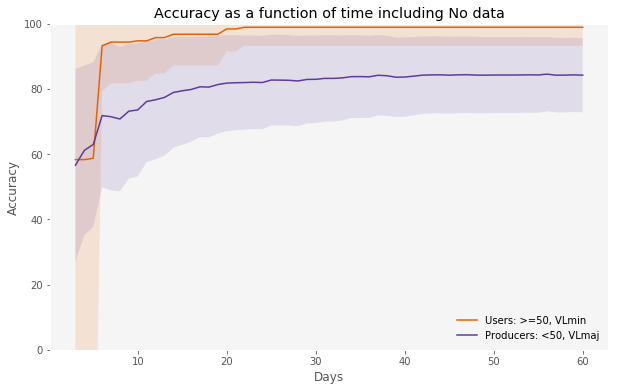

In [62]:
yuall = np.array([row[0] for row in users[0:58]])
yuerr = np.array([row[1] for row in users[0:58]])
ypall = np.array([row[0] for row in producers[0:58]])
yperr = np.array([row[1] for row in producers[0:58]])

x = range(3,61)
#pal = ["#1d3251","#003251","#1c5c68","#81b6bd","#61b6bd","#accbc7","#005c68","#8ccbc7"]#["#173f5f","#3caea3","#20639b","#88deb0"]#"#20639b","#9cfec3"]
plt.clf()
fig=0
#fig = matplotlib.pyplot.figure(figsize=(8.0, 5.0)) # in inches!
labs = ['Users: >=50, VLmin','Producers: <50, VLmin']

#plt.stackplot(x,y,colors=sns.color_palette('ocean',10)[2:10])
#plt.stackplot(x,y,colors=sns.color_palette('YlGnBu_r',10)[0:8])
#plt.stackplot(x,y,colors=myLSpal3,labels=labs)
#leg = plt.legend(reversed(plt.legend().legendHandles),reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
#pal = ["#D49937","#2E7B8A"]
pal = ["#E66100","#5D3A9B"]
plt.figure(figsize=(10,6))
plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
plt.plot(x,yuall,color=pal[0],label='Users: >=50, VLmin')
plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
plt.plot(x,ypall,color=pal[1],label='Producers: <50, VLmaj')


#plt.plot(x,200*(yuall/100)*(ypall/100)/((yuall/100)+(ypall/100)),color="black",label='F1')
leg2 = plt.legend(reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
plt.setp(leg2.get_texts(), color='#444444')
#plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x, ',')))
#plt.errorbar(x,yall,yerr,linestyle='')
#plt.rcParams['hatch.linewidth'] = 0.3
#errorparams = {hatch='///',facecolor='#44444400',edgecolor='#44444455'}
#plt.fill_between(x, yall-yerr, yall+yerr, hatch='...',facecolor='#44444400',edgecolor='#44444455',linewidth=0.1)
#paldark = ["#0d2241","#0c4c58","#71a6ad","#9cbbb7"]
plt.legend(loc='lower right',framealpha=0)
#plt.margins(0)
plt.ylim(0,100)
plt.title('Accuracy as a function of time including No data')
plt.ylabel('Accuracy')#²')
plt.xlabel('Days')#²')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")

plt.show()
#plt.savefig('figures/LSwaterarea30m_wliv5_upd_nogrid.pdf',bbox_inches='tight')

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

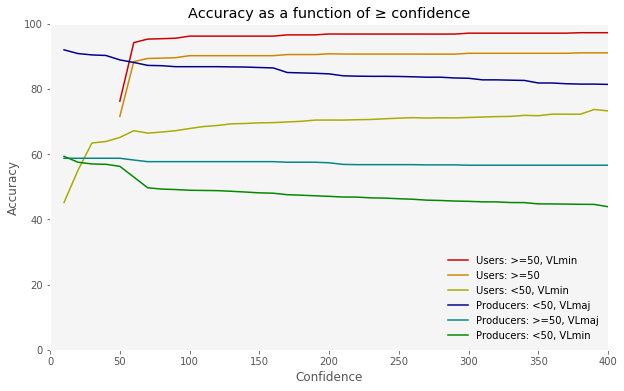

In [64]:
pal = ['#cc0000','#cc8800','#aaaa00','#000088','#008888','#008800']#["#E66100","#E66100","#D49937","#5D3A9B","#5D3A9B"]
#pal =["#E66100","#5D3A9B"]
plt.clf()
plt.figure(figsize=(10,6))
i=0
#for cattype in [usersConfVLmin,producersConf]:#[usersConfVLmin,usersConf,usersConflt50VLmin,producersConf,producersConfgt50,producersConfVLmin]:
for cattype in [usersConfVLmin,usersConf,usersConflt50VLmin,producersConf,producersConfgt50,producersConfVLmin]:
    yuall = np.array([row[1] for row in cattype])
    yuerr = np.array([row[2] for row in cattype])
    x = np.array([row[0] for row in cattype])
    #plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[i]+'11',linewidth=0.1)#47146722
    plt.plot(x,yuall,color=pal[i])
    i+=1
labs = ['Users: >=50, VLmin','Users: >=50','Users: <50, VLmin','Producers: <50, VLmaj','Producers: >=50, VLmaj','Producers: <50, VLmin']
#labs = ['Users: >50, VLmin','Producers: <50, VLmaj']

#pal = ["#D49937","#2E7B8A"]

#plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
#plt.plot(x,yuall,color=pal[0],label='Users')
#plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
#plt.plot(x,ypall,color=pal[1],label='Producers')

plt.legend(labels=labs,loc='lower right',framealpha=0)
#plt.margins(0)
plt.ylim(0,100)
plt.xlim(0,400)
plt.title('Accuracy as a function of ≥ confidence')#, inc No-data')
plt.ylabel('Accuracy')#²')
plt.xlabel('Confidence')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")
#fig = plt.gcf()
#fig.set_size_inches(5,3)
#plt.savefig('monthlywaterareaLegend.svg')
plt.show()
#plt.savefig('figures/LSwaterarea30m_wliv5_upd_nogrid.pdf',bbox_inches='tight')

[[50.0, 57.71176573171832, 134.56331953362806], [175.0, 98.07743821466579, 7.450572871032539], [375.0, 98.62096061769863, 4.903554654684352], [700.0, 100.0, nan]]


/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

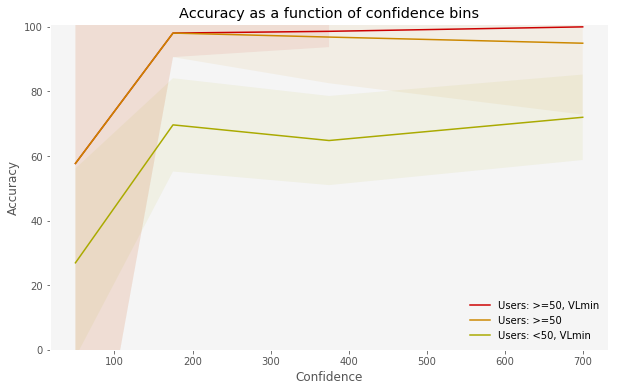

In [65]:
pal = ['#cc0000','#cc8800','#aaaa00','#000088','#008888','#008800']#["#E66100","#E66100","#D49937","#5D3A9B","#5D3A9B"]
#pal =["#E66100","#5D3A9B"]
plt.clf()
plt.figure(figsize=(10,6))
i=0
print(usersConfBinVLmin)
#for cattype in [usersConfVLmin,producersConf]:#[usersConfVLmin,usersConf,usersConflt50VLmin,producersConf,producersConfgt50,producersConfVLmin]:
for cattype in [usersConfBinVLmin,usersConfBin,usersConfBinlt50VLmin]:#,producersConfBin,producersConfBingt50,producersConfBinVLmin]:
    yuall = np.array([row[1] for row in cattype])
    yuerr = np.array([row[2] for row in cattype])
    x = np.array([row[0] for row in cattype])
    plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[i]+'11',linewidth=0.1)#47146722
    plt.plot(x,yuall,color=pal[i])
    i+=1
labs = ['Users: >=50, VLmin','Users: >=50','Users: <50, VLmin']#,'Producers: <50, VLmaj','Producers: >=50, VLmaj','Producers: <50, VLmin']
#labs = ['Users: >50, VLmin','Producers: <50, VLmaj']

#pal = ["#D49937","#2E7B8A"]

#plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
#plt.plot(x,yuall,color=pal[0],label='Users')
#plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
#plt.plot(x,ypall,color=pal[1],label='Producers')

plt.legend(labels=labs,loc='lower right',framealpha=0)
#plt.margins(0)
plt.ylim(0,101)
#plt.xlim(0,400)
plt.title('Accuracy as a function of confidence bins')#, inc No-data')
plt.ylabel('Accuracy')#²')
plt.xlabel('Confidence')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")
#fig = plt.gcf()
#fig.set_size_inches(5,3)
#plt.savefig('monthlywaterareaLegend.svg')
plt.show()
#plt.savefig('figures/LSwaterarea30m_wliv5_upd_nogrid.pdf',bbox_inches='tight')

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

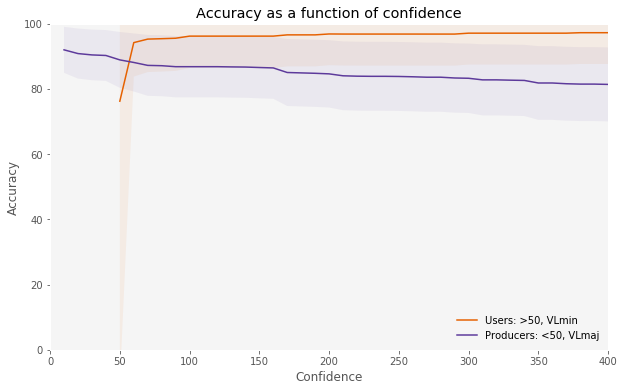

In [66]:
#pal = ['#cc0000','#cc8800','#aaaa00','#000088','#008888','#008800']#["#E66100","#E66100","#D49937","#5D3A9B","#5D3A9B"]
pal =["#E66100","#5D3A9B"]
plt.clf()
plt.figure(figsize=(10,6))
i=0
for cattype in [usersConfVLmin,producersConf]:#[usersConfVLmin,usersConf,usersConflt50VLmin,producersConf,producersConfgt50,producersConfVLmin]:
#for cattype in [usersConfVLmin,usersConf,usersConflt50VLmin,producersConf,producersConfgt50,producersConfVLmin]:
    yuall = np.array([row[1] for row in cattype])
    yuerr = np.array([row[2] for row in cattype])
    x = np.array([row[0] for row in cattype])
    plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[i]+'11',linewidth=0.1)#47146722
    plt.plot(x,yuall,color=pal[i])
    i+=1
#labs = ['Users: >=50, VLmin','Users: >=50','Users: <50, VLmin','Producers: <50, VLmaj','Producers: >=50, VLmaj','Producers: <50, VLmin']
labs = ['Users: >50, VLmin','Producers: <50, VLmaj']

#pal = ["#D49937","#2E7B8A"]

#plt.fill_between(x, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)#47146722
#plt.plot(x,yuall,color=pal[0],label='Users')
#plt.fill_between(x, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
#plt.plot(x,ypall,color=pal[1],label='Producers')

plt.legend(labels=labs,loc='lower right',framealpha=0)
#plt.margins(0)
plt.ylim(0,100)
plt.xlim(0,400)
plt.title('Accuracy as a function of confidence')
plt.ylabel('Accuracy')#²')
plt.xlabel('Confidence')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")
#fig = plt.gcf()
#fig.set_size_inches(5,3)
#plt.savefig('monthlywaterareaLegend.svg')
plt.show()
#plt.savefig('figures/LSwaterarea30m_wliv5_upd_nogrid.pdf',bbox_inches='tight')

# DIST-ANN accuracy

In [8]:
def getDISTANNbinary(yes,nodata,threshold=False):
  with open(mapsource + '/All_DIST-ANN_'+ANNname+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_IND_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_DUR,VEG_DIST_COUNT,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_DUR,GEN_DIST_COUNT) = line.strip().split(',')
    if not threshold:
      if int(VEG_DIST_STATUS) in yes:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
    else:
      if int(VEG_DIST_STATUS) in yes and int(VEG_ANOM_MAX) >= threshold:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
  return mapann

In [18]:
def getRefANNbinaryFilterDaily(yeslabels,maybelabels,yesmincount,maybemincount):
  with open('/gpfs/glad3/HLSDIST/Validation/analysis/referenceTimeSeries_last.csv','r') as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
    labels = fields[5:]
    yescount = 0
    maybecount = 0
    datacount = 0
    first = 0
    for l in labels:
      if l != "noObs" and first == 0:
        first = l
      if l in yeslabels:
        yescount +=1
      elif l in maybelabels:
        maybecount +=1
      if l != "noObs":
        datacount +=1
    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
      refann[ID] = 2
    elif datacount >= 1:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

def getRefANNbinary(yeslabels,maybelabels,yesmincount,maybemincount):
  with open('/gpfs/glad3/HLSDIST/Validation/analysis/referenceSimple_last.csv','r') as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
    labels = fields[5:]
    yescount = 0
    maybecount = 0
    datacount = 0
    first = 0
    for l in labels:
      if l != "noObs" and first == 0:
        first = l
      if l in yeslabels:
        yescount +=1
      elif l in maybelabels:
        maybecount +=1
      if l != "noObs":
        datacount +=1
    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
      refann[ID] = 2
    elif datacount >= 1:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

In [20]:
def annualConfusionMatrix(map,ref,strataCounts,excludelist=[0],printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in range(1,Nstrata)])
  #print("Total pixels:", Ntotal," Nstrata:",Nstrata)
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  #print(excludelist)
  refVLmaj = []
  #confusion matrix
  for ID in ids:
    if int(ID) in refVLmaj:
      ref[ID] = 2
    if not (int(map[ID])==2 and int(ref[ID])==1 and int(ID) in excludelist):
      n[strata[ID]][int(ref[ID])][int(map[ID])] += 1
      if ref[ID] >0 and map[ID]>0:
        ntotal[strata[ID]] += 1
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [15]:
def getDISTANN_new(file,yes,nodata):
  with open(file+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_IND_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_DUR,VEG_DIST_COUNT,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_DUR,GEN_DIST_COUNT)= line.strip().split(',')
    #(temp,ID,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_COUNT,VEG_DIST_DUR,VEG_HIST,VEG_IND_MAX) = line.strip().split(',')
    if int(VEG_DIST_STATUS) in yes:
       mapann[ID] = 2
    elif int(VEG_DIST_STATUS) in nodata:
       mapann[ID] = 0
    else:
       mapann[ID] = 1
  return mapann

In [24]:
#ANN
file = "mapLabelsv1sample/All_DIST-ANN_v1sample"
basename = "DIST-ANN_v1"
durlist = [15,60]
for duration in durlist:
  #for threshold in [False,32,50]:
  #for threshold in [400,500,600,800]:
    #map = getDISTANNbinaryFilterConfidence([4,6],[255],threshold)
    name = basename+"_dur"+str(duration)+"_gt50"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)#"VLmaj","VLtotal","VLmin"
    #print("Duration of ref VL:",duration)#,"Threshold of VEG-ANOM:",threshold)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    #printFullList(map,ref,name)
    #printErrorList(map,ref,name)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:
  #for threshold in [False,32,50]:
  #for threshold in [400,500,600,800]:
    #map = getDISTANNbinaryFilterConfidence([4,6],[255],threshold)
    name = basename+"_dur"+str(duration)+"_lt50"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)#"VLmaj","VLtotal","VLmin"
    #print("Duration of ref VL:",duration)#,"Threshold of VEG-ANOM:",threshold)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    #printFullList(map,ref,name)
    #printErrorList(map,ref,name)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:
  #for threshold in [False,32,50]:
  #for threshold in [400,500,600,800]:
    #map = getDISTANNbinaryFilterConfidence([4,6],[255],threshold)
    name = basename+"_dur"+str(duration)+"_gt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)#"VLmaj","VLtotal","VLmin"
    #print("Duration of ref VL:",duration)#,"Threshold of VEG-ANOM:",threshold)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    #printFullList(map,ref,name)
    #printErrorList(map,ref,name)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:
  #for threshold in [False,32,50]:
  #for threshold in [400,500,600,800]:
    #map = getDISTANNbinaryFilterConfidence([4,6],[255],threshold)
    name = basename+"_dur"+str(duration)+"_lt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)#"VLmaj","VLtotal","VLmin"
    #print("Duration of ref VL:",duration)#,"Threshold of VEG-ANOM:",threshold)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    #printFullList(map,ref,name)
    #printErrorList(map,ref,name)
    accuracy(n,ntotal,strataCounts,name,True)


DIST-ANN_v1_dur15_gt50
99.21937661507565 0.16083426379019913
0.3866013931347914 0.2331877279993749
Overall: 99.45256434307503  +- 0.1496886373343868
Users: 59.18139922603811  +- 17.950038280308416
Producers: 37.623720721760876  +- 10.57117604672322

DIST-ANN_v1_dur60_gt50
99.45304955703259 0.26570558658472354
0.15292845117787107 0.12831640520485046
Overall: 99.58136596223743  +- 0.1452219108554133
Users: 32.56579781805107  +- 12.32362340483713
Producers: 45.62444513838002  +- 14.061596754643894

DIST-ANN_v1_dur15_lt50
97.11117406602156 2.269036812844296
0.13546004640141107 0.4843290747327552
Overall: 97.59550314075429  +- 0.3408629973162374
Users: 17.59043637890649  +- 4.415133515790251
Producers: 78.14417165736474  +- 7.353695090151296

DIST-ANN_v1_dur60_lt50
97.188649123102 2.5301060205152854
0.05798498932095541 0.2232598670617661
Overall: 97.41190899016375  +- 0.34414798794532825
Users: 8.108616005925521  +- 2.7486983684770334
Producers: 79.38273785101735  +- 10.18726212017529

DIS